In [1]:
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pandas_datareader.data as pdr 
from datetime import datetime, timedelta
import os 
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
class WSJ__Scraper:
    """Useful for income statements"""
    def __init__(self):
        self.baseUrl = "https://www.wsj.com"
        
    
    def __createDataframeFromIncomeStatementTable(self, table):
        rows = table.findAll("tr")
        dates = [ str(el).strip("<th>").strip("</th>") for el in table.findAll("th")[1:-1] ]    
        data = { "Dates": dates }
        for row in rows:
            tds = row.findAll("td")
            if len(tds) > 0 and tds[0].text != "":
                data[tds[0].text] = [ td.text for td in tds[1:len(dates)+1] ]
        df = pd.DataFrame(data)
        df = df.set_index("Dates")
        return df        
    
    
    def __parseIncomeStatementsFromHtml(self, html):
        """Parse the income statement table as a dataframe"""
        soup = BeautifulSoup(html, 'html.parser')
        incomeStatementTable = soup.findAll("table", { "class": "cr_dataTable" })[0]
        return self.__createDataframeFromIncomeStatementTable(incomeStatementTable)
    
        
    def __getIncomeStatements(self, ticker, period):
        """
        Get income statements from WSJ
        Period = [ 'quarter', 'annual' ]
        """
        url = f"{self.baseUrl}/market-data/quotes/{ticker}/financials/{period}/income-statement"
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return self.__parseIncomeStatementsFromHtml(response.content)
        raise Exception(f"Bad request: status {response.status_code}")
        
        
    def getQuarterlyIncomeStatements(self, ticker):
        return self.__getIncomeStatements(ticker, "quarter")
    
    
    def getAnnualIncomeStatements(self, ticker):
        return self.__getIncomeStatements(ticker, "annual")


In [7]:
class MacroTrends__Scraper:
    def __init__(self, ticker):
        self.headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        self.baseUrl = requests.get(f"https://www.macrotrends.net/stocks/charts/{ticker}", headers=self.headers).url
        self.saveFolder = "./saved_data"
        self.ticker = ticker
        
    def __sendRequest(self, slug):
        url = self.baseUrl + slug
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
        return requests.get(url, headers=headers)
    
    
    def __parseDataTable(self, html):
        soup = BeautifulSoup(html, 'html.parser')
        table = soup.findAll("div", { "id": "style-1" })[0].findAll("table")[0]
        labels = [ th.text for th in table.findAll("th") ][1:]
        rows = table.findAll("tr")[2:]
        data = []
        for row in rows:
            data.append([ td.text for td in row.findAll("td") ])
        df = pd.DataFrame(data, columns=labels).set_index("Date")
        if '%' in df.iloc[0][-1]:
            df.iloc[:,-1] = df.iloc[:,-1].str.strip("%").astype(float) / 100
        return df
            
        
    def __getTableData(self, slug):
        html = self.__sendRequest(slug).content
        return self.__parseDataTable(html)
    
    def getPERatio(self):
        return self.__getTableData("pe-ratio")
                                     
    def getPSRatio(self):
        return self.__getTableData("price-sales")
                                     
    def getPriceBookRatio(self):
        return self.__getTableData("price-book")
                                     
    def getPriceFCFRatio(self):
        return self.__getTableData("price-fcf")
    
    def getCurrentRatio(self):
        return self.__getTableData("current-ratio")
    
    def getQuickRatio(self):
        return self.__getTableData("quick-ratio")
    
    def getDebtEquityRatio(self):
        return self.__getTableData("debt-equity-ratio")
    
    def getROE(self):
        return self.__getTableData("roe")
    
    def getROA(self):
        return self.__getTableData("roa")
    
    def getROI(self):
        return self.__getTableData("roi")
    
    def getReturnOnTangibleEquity(self):
        return self.__getTableData("return-on-tangible-equity")
    
    def __saveFileNameForRatios(self):
        return f"{self.saveFolder}/{self.ticker}_ratios.csv"
    
    def __getSavedRatios(self):
        f = self.__saveFileNameForRatios()
        if os.path.exists(f):
            return pd.read_csv(f).set_index("Date")
        return None
        
    def __getAllRatios(self):
        perRatio = self.getPERatio()
        df = pd.DataFrame({
            "PE Ratio": perRatio.iloc[:,-1],
            "PS Ratio": self.getPSRatio().iloc[:,-1],
            "Price Book Ratio": self.getPriceBookRatio().iloc[:,-1],
            "Price FCF Ratio": self.getPriceFCFRatio().iloc[:,-1],
            "Current Ratio": self.getCurrentRatio().iloc[:,-1],
            "Quick Ratio": self.getQuickRatio().iloc[:,-1],
            "Debt Equity Ratio": self.getDebtEquityRatio().iloc[:,-1],
            "ROE": self.getROE().iloc[:,-1],
            "ROA": self.getROA().iloc[:,-1],
            "ROI": self.getROI().iloc[:,-1],
            "Return On Tangible Equity": self.getReturnOnTangibleEquity().iloc[:,-1]
        }, index=perRatio.index)
        df.to_csv(self.__saveFileNameForRatios())
        return df
    
    def getAllRatios(self):
        df = self.__getSavedRatios()
        if df is None:
            print("Ratios not previously saved. Fetching data...")
            df = self.__getAllRatios()
            print("Done")
        return df
        
    

In [8]:
class StockData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.saveFolder = "./saved_data"
    
    def getTickerData(self, start, end):
        return pdr.DataReader(self.ticker, 'yahoo', start, end)
    
    def getClosingPriceForDates(self, dates, daysOffset):
        datesOffset = [ datetime.strptime(date, "%Y-%m-%d")+timedelta(days=daysOffset) for date in dates ]
        datesOffset = [ date.strftime("%Y-%m-%d") for date in datesOffset if date < date.today() ]
        data = [ self.getTickerData(date, None)["Close"].iloc[0] for date in datesOffset ]
        return pd.DataFrame(data, columns=[self.ticker], index=dates[-len(data):])
        
    def getAllData(self, daysOffset, cleanCache=False):
        scraper = MacroTrends__Scraper(self.ticker)
        df = scraper.getAllRatios()
        
        startDate = df.index[0]
        endDate = df.index[-1]
        fileName = self.__fileName(startDate, endDate, daysOffset)
        
        if not cleanCache and os.path.exists(fileName):
            return pd.read_csv(fileName).set_index("Date")
        
        closingPrices = self.getClosingPriceForDates(df.index, daysOffset)
        df["Share Price"] = closingPrices
        df.to_csv(fileName)
        return df 

    def __fileName(self, startDate, endDate, offSet):
        return f"{self.saveFolder}/{self.ticker}_data_{startDate}-{endDate}-{offSet}days"
    

In [9]:
class Company_Valuation:
    def __init__(self, ticker, offSet, cleanCache=False, normalize=False):
        self.data = StockData(ticker).getAllData(offSet, cleanCache)
        self.data = self.data.drop(["ROE", "ROA", "ROI"], axis=1)
        self.data.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.data = self.data.dropna()
        if normalize:
            self.data = self.__normalizeData()
            self.data.replace([np.inf, -np.inf], np.nan, inplace=True)
            self.data = self.data.dropna()
        self.ticker = ticker
        self.offSet = offSet
        
    def __normalizeData(self):
        a = np.array(self.data)
        return pd.DataFrame((a[:-1] - a[1:]) / a[1:], columns=self.data.columns, index=self.data.index[:-1])        
    
    def __splitDataRandom(self, test_size=0.2):
        test_data = self.data.sample(frac=test_size)
        train_data = self.data.sample(frac=1-test_size)
        return train_data, test_data
    
    def __splitData(self, test_size=0.2):
        dataLength = self.data.shape[0]
        train_data = self.data.iloc[int(dataLength*test_size):]
        test_data = self.data.iloc[:int(dataLength*test_size)]
        return train_data, test_data
    
    def __trainRegression(self, xtrain, ytrain):
        regr = linear_model.LinearRegression()
        regr.fit(xtrain, ytrain)
        print("Score:", regr.score(xtrain, ytrain))
        return regr
    
    def __predict(self, regr, xtest):
        return regr.predict(xtest)

    def regress(self, targetCol="Share Price"):
        train_data, test_data = self.__splitData()
        xtrain = train_data.drop([targetCol], axis=1)
        ytrain = train_data[targetCol]
        xtest = test_data.drop([targetCol], axis=1)
        ytest = test_data[targetCol]
        
        regr = self.__trainRegression(xtrain, ytrain)
        pred = self.__predict(regr, xtest)
        return xtrain, ytrain, xtest, ytest, pred 
    
    def plotRegression(self, targetCol="Share Price"):
        xtrain, ytrain, xtest, ytest, pred = self.regress()
        plt.title(f"Prediction of Ratios on Share Price of {self.ticker} ({self.offSet} days lagged)")
        plt.plot(xtest.index, pred, color='red', label="Prediction")
        plt.plot(xtest.index, ytest, label="Actual")
        plt.plot(xtest.index, np.zeros(len(pred)), color="black")
        plt.legend()
    
    
    def simulateUsingRegression(self):
        _, _, _, actual, pred = self.regress()
        inMarket = 1
        cash = 0
        for i in range(len(pred)):
            # sell
            if pred[i] < 0:
                cash = inMarket
                inMarket = 0
        
            # buy
            else:
                inMarket = cash if cash > 0 else inMarket
                cash = 0 
                inMarket *= 1+actual[i]
        return inMarket + cash 
            
                
    

In [11]:
cv = Company_Valuation('MSFT', 30, False, normalize=True)
_, _, _, actual, _ = cv.regress()
cv.plotRegression()
cv.simulateUsingRegression()

Ratios not previously saved. Fetching data...
Done


NameError: name 'np' is not defined

Score: 0.12069728900684261


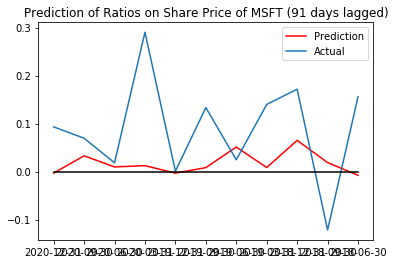

In [598]:
Company_Valuation('MSFT', 365//4, False, normalize=True).plotRegression()


Score: 0.06565207634326153


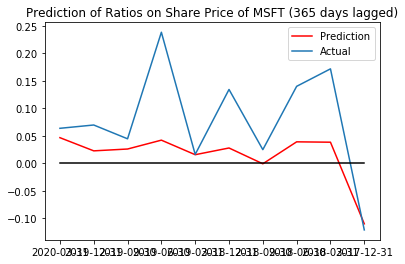

In [599]:
Company_Valuation('MSFT', 365, False, normalize=True).plotRegression()


Score: 0.9549277456430666


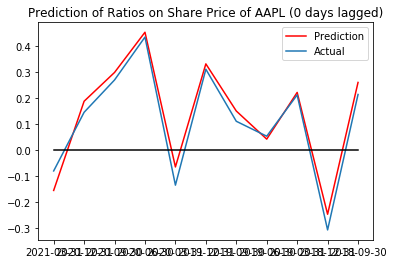

In [600]:
Company_Valuation('AAPL', 00, False, normalize=True).plotRegression()


Score: 0.3893419708739351


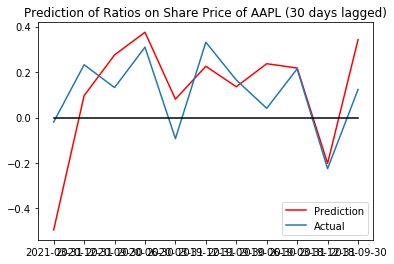

In [601]:
Company_Valuation('AAPL', 30, False, normalize=True).plotRegression()


Score: 0.18650309678949428


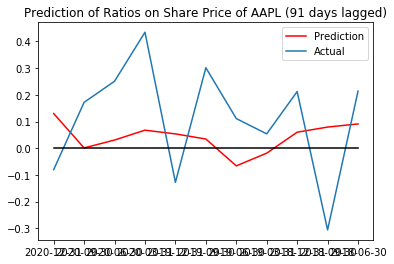

In [602]:
Company_Valuation('AAPL', 365//4, False, normalize=True).plotRegression()



Score: 0.12069728900684261


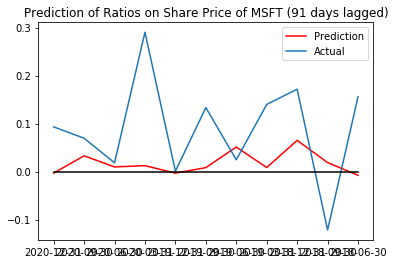

In [606]:
Company_Valuation('MSFT', 365//4, False, normalize=True).plotRegression()

